# Image Segmentation on Forest Imagery

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [109]:
### import required packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

In [118]:
base_dir = 'data_new'

original_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')


In [119]:
# Load and preprocess original image

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.resize(img, [224, 224])  
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [185]:
# Load mask

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.cast(alpha_channel > 0, tf.float32)

    # Resize the binary mask to match (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [186]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [187]:
# Get list of all images and masks
original_paths = sorted([os.path.join(original_dir, fname) for fname in os.listdir(original_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [188]:
# Create TensorFlow Dataset from the file paths of original images and masks
dataset = tf.data.Dataset.from_tensor_slices((original_paths, mask_paths))
print(dataset.element_spec)
buffer_size = 1000
dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [189]:
# Split the dataset into training, validation, and test datasets
total_count = len(list(dataset))
train_count = int(0.7 * total_count)
validation_count = int(0.1 * total_count)
test_count = int(0.2 * total_count)


train_dataset = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_dataset = remaining.take(validation_count)
test_dataset = remaining.skip(validation_count)

2024-11-19 17:26:35.376646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.377216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.394893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.399575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.403159: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.403353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.425410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.439463: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 17:26:35.441662: W tensorflow/core/lib/png/png_io.cc:89] PNG 

In [190]:
validation_count

12

### Visualizing the Images

In [191]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask',]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

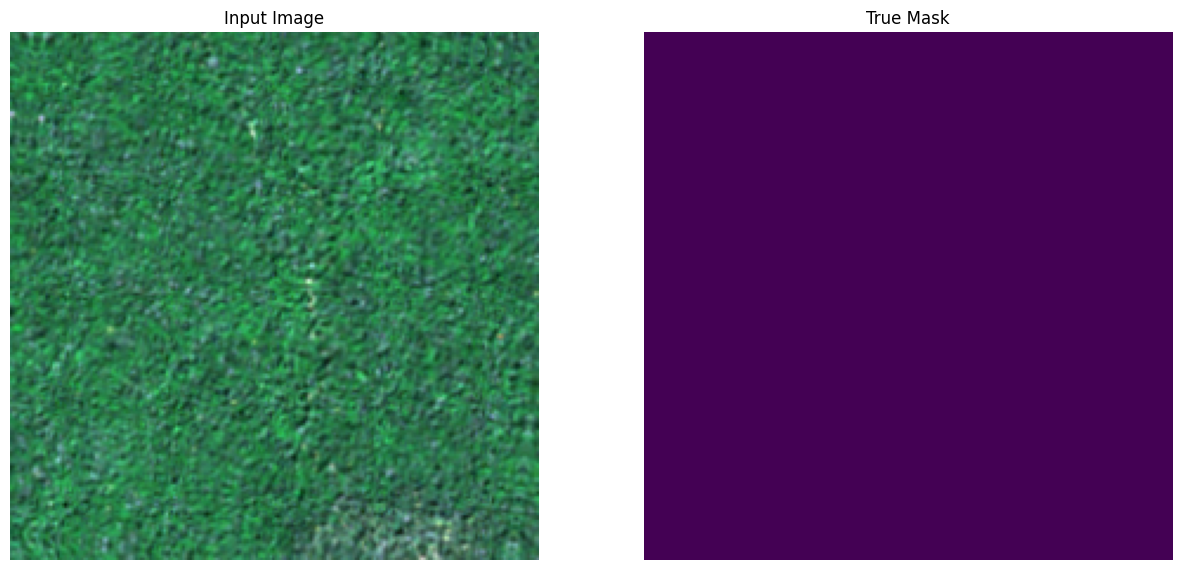

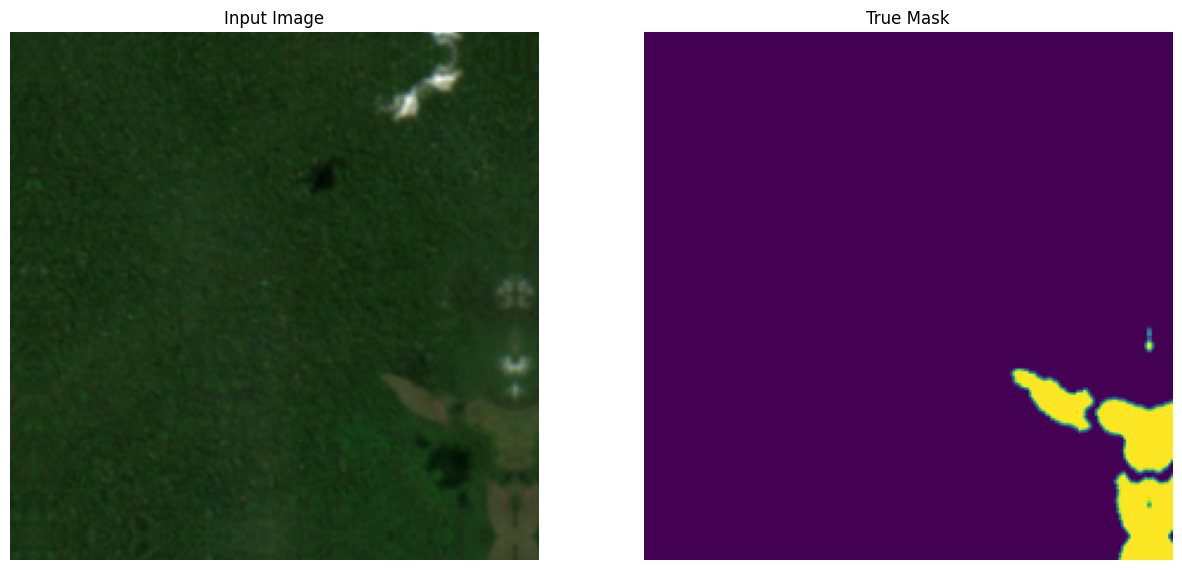

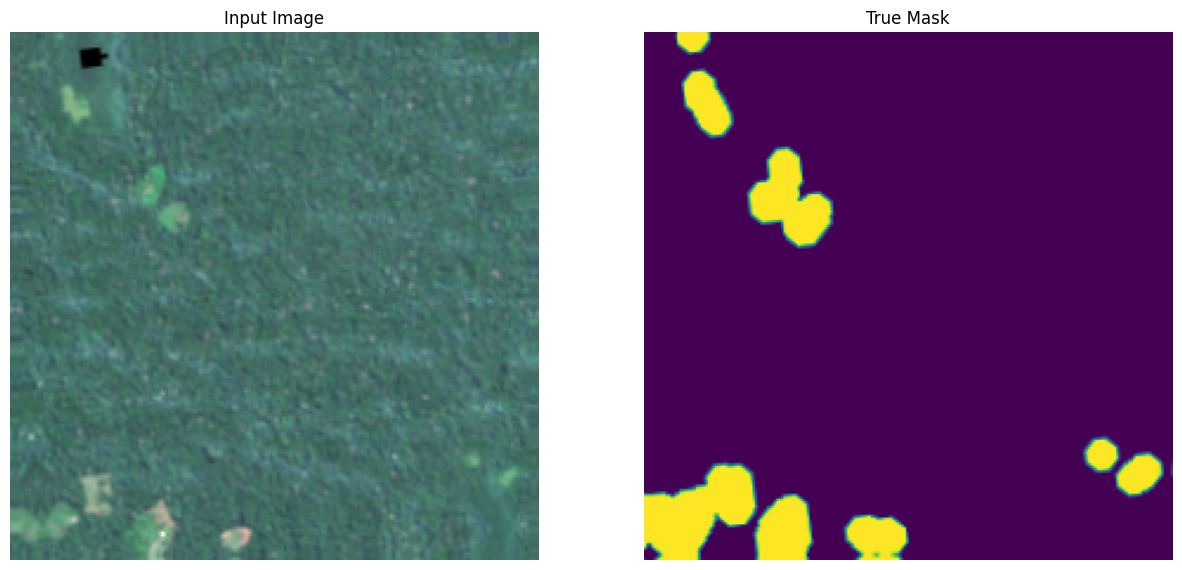

In [192]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Prepare for Modeling

In [193]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(0.2, seed=seed),
            tf.keras.layers.RandomZoom(0.2, seed=seed)
        ])
        
    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomZoom(0.2, seed=seed)
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [194]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [195]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Prepare the validation dataset without data augmentation
validation_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Prepare the test dataset without data augmentation
test_batches = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [196]:
from tensorflow_examples.models.pix2pix import pix2pix

# Pretrained network
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Specific layers in MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freezing Weights for Pretrained Model
down_stack.trainable = False


In [197]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [198]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [236]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true,[1, 2, 3]) + tf.reduce_sum(y_pred,[1, 2, 3]) - intersection
    iou = intersection / union
    return iou

In [227]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

## Training

In [167]:
EPOCHS = 20
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/20


2024-11-19 16:39:01.560579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.569616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.572724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.575581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.584884: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.588102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.598109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.603812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.603905: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6432 - iou_metric: 0.0849 - loss: 0.6299

2024-11-19 16:39:06.872667: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.876272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.883421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.888172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.897871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.900858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.902364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.903716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.907731: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6545 - iou_metric: 0.0825 - loss: 0.6224 - val_accuracy: 0.7971 - val_iou_metric: 0.0450 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7898 - iou_metric: 0.0306 - loss: 0.5177 - val_accuracy: 0.8401 - val_iou_metric: 0.0141 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8363 - iou_metric: 0.0212 - loss: 0.4204 - val_accuracy: 0.8483 - val_iou_metric: 0.0070 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8158 - iou_metric: 0.0205 - loss: 0.4094 - val_accuracy: 0.8503 - val_iou_metric: 0.0177 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7831 - iou_metric: 0.0286 - loss: 0.4325 - val_accuracy: 0.8500 - val_iou_metric: 0.0590 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

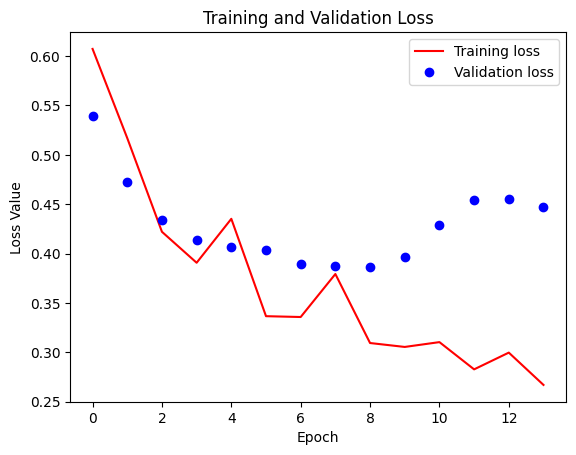

In [168]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

## K-Fold Cross Validation

In [241]:
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5
EPOCHS = 20
BATCH_SIZE = 32
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

dataset_size = len(list(dataset))  # Get the total size of the dataset

# Split the dataset into 80% training and 20% test sets
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Use Dataset.take() and Dataset.skip() to split the dataset
train_dataset_full = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Initialize KFold from scikit-learn
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    # Split dataset into training and validation sets for this fold
    # train_data = [dataset_list[i] for i in train_idx]
    # val_data = [dataset_list[i] for i in val_idx]

    train_dataset_full_copy = train_dataset_full
    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(Augment())
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule]
    )

    # Evaluate on validation set for this fold
    val_loss, val_accuracy, val_iou = model.evaluate(val_dataset)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy}")

2024-11-19 18:15:15.849325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.850375: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.852058: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.859810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.863202: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.867522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.873729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.889384: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:15.894922: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Training fold 1/5...


2024-11-19 18:15:16.530779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.540107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.540927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.545246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.546976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.553101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.553885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.569263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:16.571298: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 224, 224, 1)
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.2509 - iou_metric: 0.1546 - loss: 1.0136

2024-11-19 18:15:22.371517: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.371607: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.371668: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.375149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.377670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.380387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.382119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.386117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:22.393703: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2590 - iou_metric: 0.1573 - loss: 1.0052 - val_accuracy: 0.5201 - val_iou_metric: 0.1092 - val_loss: 0.7980 - learning_rate: 0.0010
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5152 - iou_metric: 0.1173 - loss: 0.7234 - val_accuracy: 0.6511 - val_iou_metric: 0.0857 - val_loss: 0.6093 - learning_rate: 0.0010
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6475 - iou_metric: 0.1045 - loss: 0.6094 - val_accuracy: 0.7599 - val_iou_metric: 0.0410 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7971 - iou_metric: 0.0375 - loss: 0.5021 - val_accuracy: 0.8475 - val_iou_metric: 0.0099 - val_loss: 0.4255 - learning_rate: 0.0010
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7647 - iou_metric: 0.0161 - loss: 0.5250 - val_accuracy: 0.8497 - val_iou_metric: 0.0027 - val_loss: 0.3866 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - accuracy:

2024-11-19 18:15:39.366541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.374830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.380211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.382896: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.388930: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.394064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.395838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.397225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:39.399304: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 224, 224, 1)
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5848 - iou_metric: 0.1177 - loss: 0.7538

2024-11-19 18:15:45.647859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.648040: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.648858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.651088: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.651196: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.674049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.675412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.686856: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:15:45.690820: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5961 - iou_metric: 0.1106 - loss: 0.7368 - val_accuracy: 0.7837 - val_iou_metric: 0.0700 - val_loss: 0.4984 - learning_rate: 0.0010
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7368 - iou_metric: 0.0804 - loss: 0.5334 - val_accuracy: 0.8537 - val_iou_metric: 0.0144 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8016 - iou_metric: 0.0197 - loss: 0.4421 - val_accuracy: 0.8496 - val_iou_metric: 6.9969e-05 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7862 - iou_metric: 8.6989e-05 - loss: 0.4448 - val_accuracy: 0.8526 - val_iou_metric: 5.1073e-05 - val_loss: 0.3572 - learning_rate: 0.0010
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8456 - iou_metric: 2.1129e-05 - loss: 0.3562 - val_accuracy: 0.8582 - val_iou_metric: nan - val_loss: 0.3457 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/ste

2024-11-19 18:16:04.555840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.557133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.562559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.564208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.564255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.572689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.574967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.576480: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:04.586901: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 224, 224, 1)
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4719 - iou_metric: 0.1340 - loss: 0.8034

2024-11-19 18:16:10.688324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.688372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.690761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.694661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.701591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.707948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.709663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.712496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:10.713051: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4898 - iou_metric: 0.1250 - loss: 0.7864 - val_accuracy: 0.6999 - val_iou_metric: 0.0584 - val_loss: 0.5883 - learning_rate: 0.0010
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6707 - iou_metric: 0.0570 - loss: 0.6174 - val_accuracy: 0.8166 - val_iou_metric: 0.0170 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8076 - iou_metric: 0.0150 - loss: 0.4746 - val_accuracy: 0.8601 - val_iou_metric: 9.1741e-04 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8227 - iou_metric: 0.0010 - loss: 0.4618 - val_accuracy: 0.8422 - val_iou_metric: 1.3542e-05 - val_loss: 0.3980 - learning_rate: 0.0010
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8358 - iou_metric: 5.0055e-05 - loss: 0.4135 - val_accuracy: 0.8561 - val_iou_metric: 1.8134e-05 - val_loss: 0.3635 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/

2024-11-19 18:16:28.684912: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.688225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.693217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.697569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.697890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.702322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.702658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.703523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:28.708257: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 224, 224, 1)
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4436 - iou_metric: 0.1117 - loss: 0.7291

2024-11-19 18:16:37.546902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.557935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.558537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.558965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.563750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.568354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.568403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.570636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:37.571239: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4519 - iou_metric: 0.1125 - loss: 0.7225 - val_accuracy: 0.6628 - val_iou_metric: 0.1249 - val_loss: 0.6159 - learning_rate: 0.0010
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7044 - iou_metric: 0.0828 - loss: 0.5670 - val_accuracy: 0.7428 - val_iou_metric: 0.0373 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8079 - iou_metric: 0.0251 - loss: 0.4814 - val_accuracy: 0.7866 - val_iou_metric: 0.0081 - val_loss: 0.4765 - learning_rate: 0.0010
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8167 - iou_metric: 0.0058 - loss: 0.4460 - val_accuracy: 0.7899 - val_iou_metric: 0.0097 - val_loss: 0.4558 - learning_rate: 0.0010
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8411 - iou_metric: 0.0095 - loss: 0.3939 - val_accuracy: 0.7807 - val_iou_metric: 0.0171 - val_loss: 0.4585 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - accuracy:

2024-11-19 18:16:52.995519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.023842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.029710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.030120: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.033857: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.038956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.039874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.041427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:16:53.047357: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 224, 224, 1)
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5442 - iou_metric: 0.1213 - loss: 0.7562

2024-11-19 18:17:01.802525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.805919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.811650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.811706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.818440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.818753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.818925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.827183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:17:01.836719: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5516 - iou_metric: 0.1168 - loss: 0.7474 - val_accuracy: 0.6489 - val_iou_metric: 0.0814 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.6351 - iou_metric: 0.1039 - loss: 0.6174 - val_accuracy: 0.7531 - val_iou_metric: 0.0798 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7784 - iou_metric: 0.0704 - loss: 0.5068 - val_accuracy: 0.8341 - val_iou_metric: 0.0135 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7601 - iou_metric: 0.0081 - loss: 0.5029 - val_accuracy: 0.8257 - val_iou_metric: 0.0029 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8099 - iou_metric: 0.0041 - loss: 0.4227 - val_accuracy: 0.8219 - val_iou_metric: 0.0108 - val_loss: 0.3934 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy:

##  Predictions

In [245]:
test_dataset = (test_dataset
                .batch(BATCH_SIZE)  # Ensure batching
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [246]:
predict = model.predict(test_dataset)

2024-11-19 18:19:17.794334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.805837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.808897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.816684: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.819437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.837326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.839197: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.840715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:17.845388: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [247]:
predicted_masks = (predict>0.6).astype(int)

In [248]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2024-11-19 18:19:21.940840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.941754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.943792: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.958766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.959066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.966854: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.969980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.972470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:19:21.976090: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step - accuracy: 0.8516 - iou_metric: 0.0130 - loss: 0.3693
Test Loss: 0.3693465292453766
Test IOU: 0.012998338788747787
Test Accuracy: 85.16%


In [249]:
predicted_masks.shape

(25, 224, 224, 1)

2024-11-19 18:23:25.280786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.287272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.288511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.292329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.294638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.301092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.307719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.314763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 18:23:25.316754: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


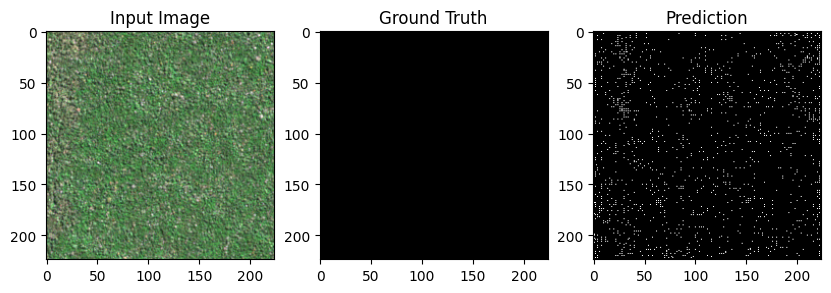

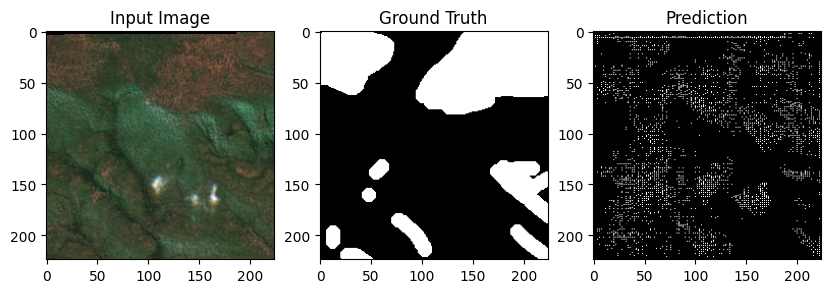

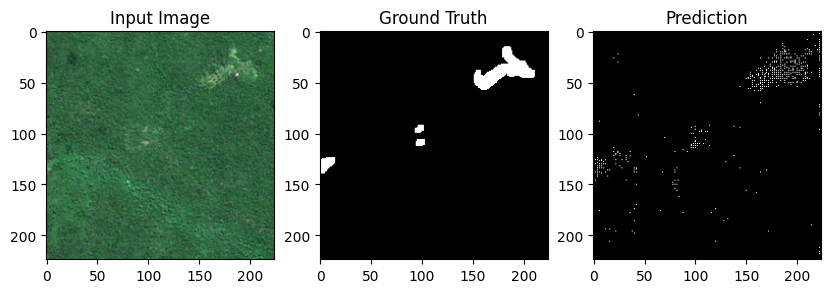

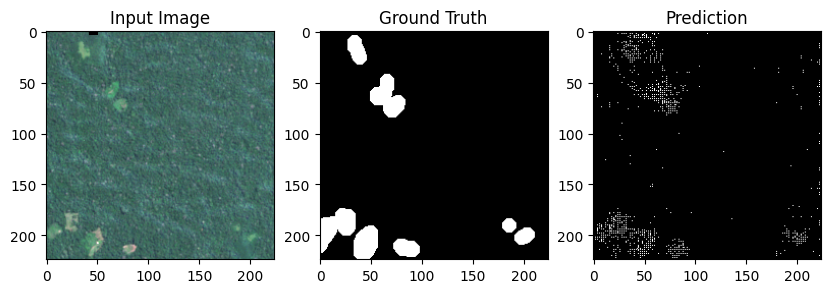

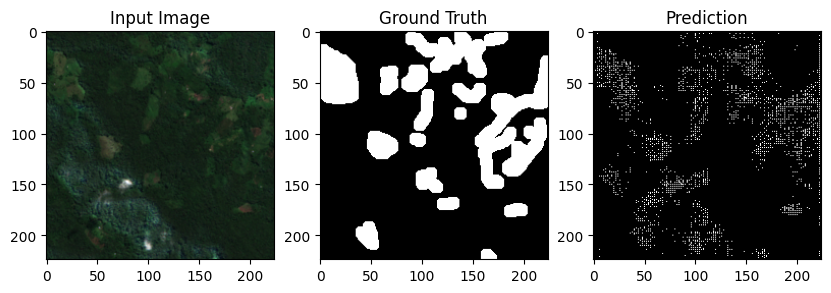

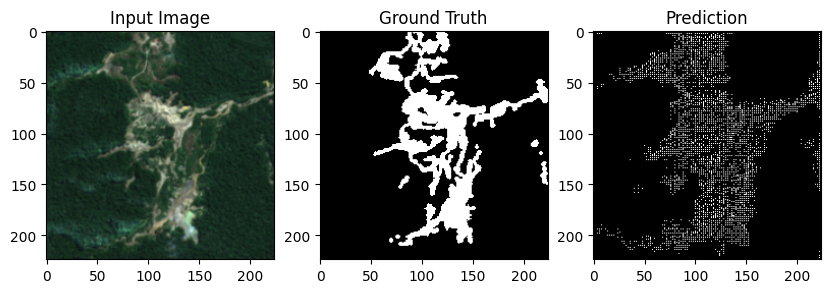

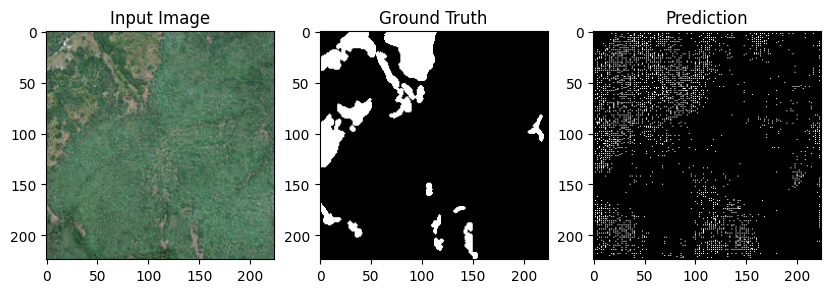

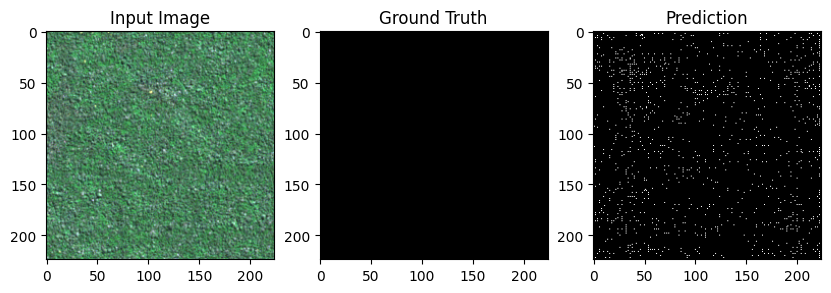

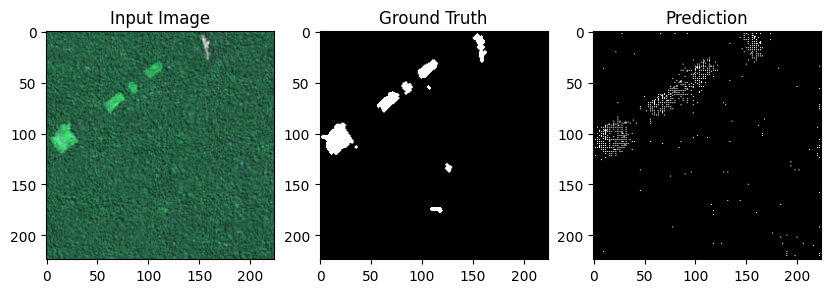

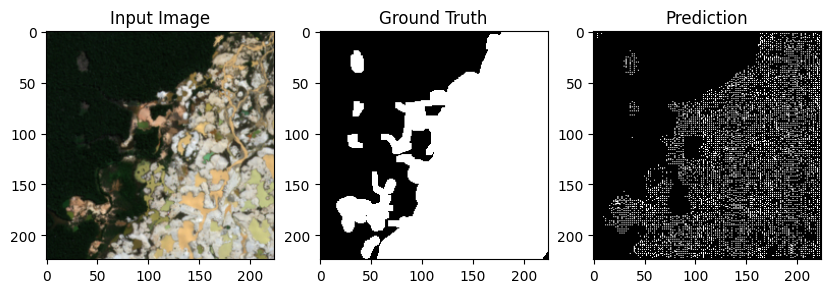

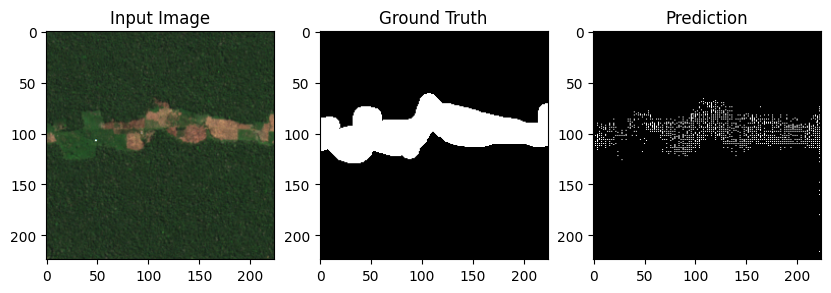

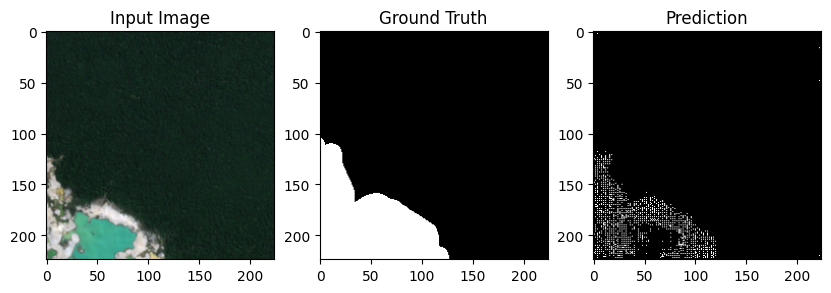

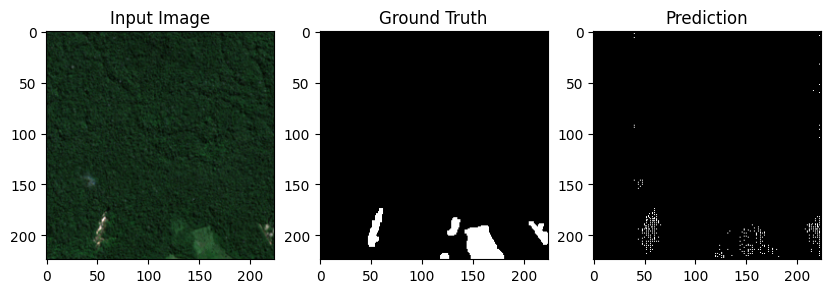

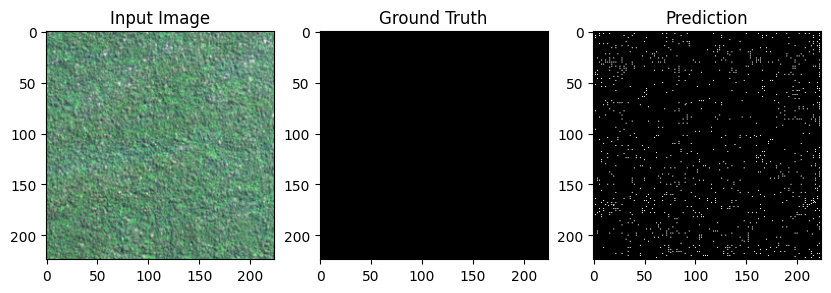

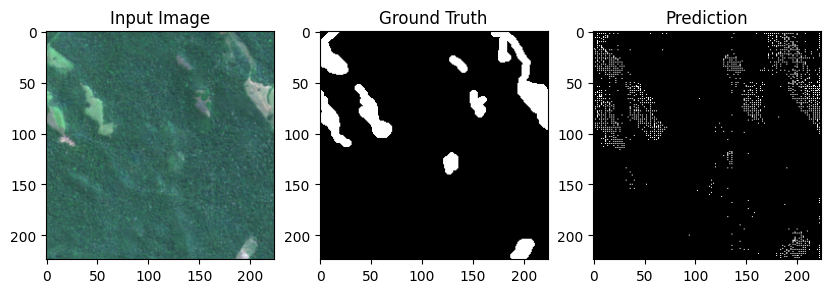

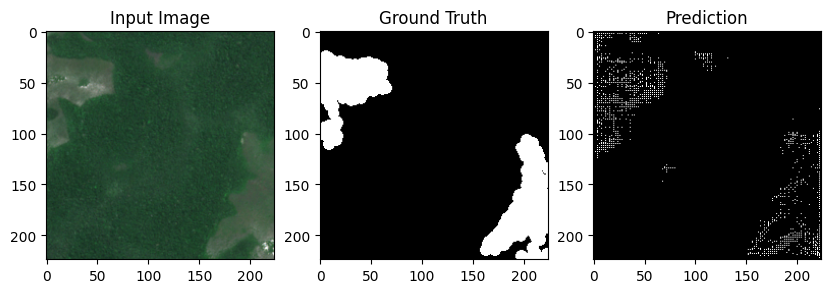

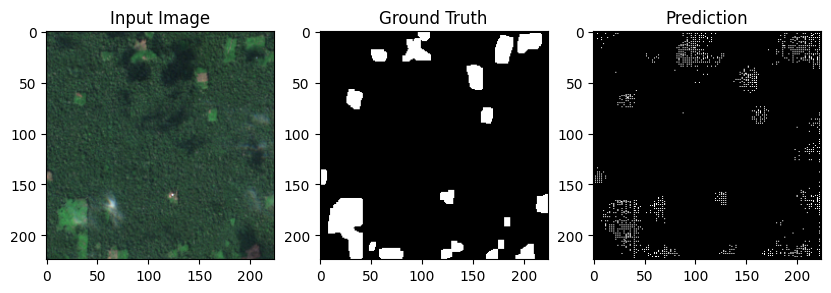

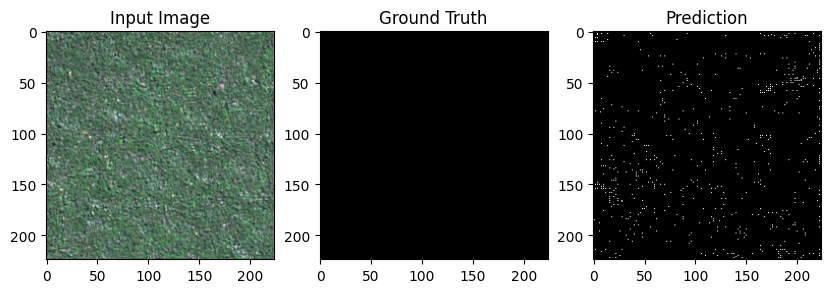

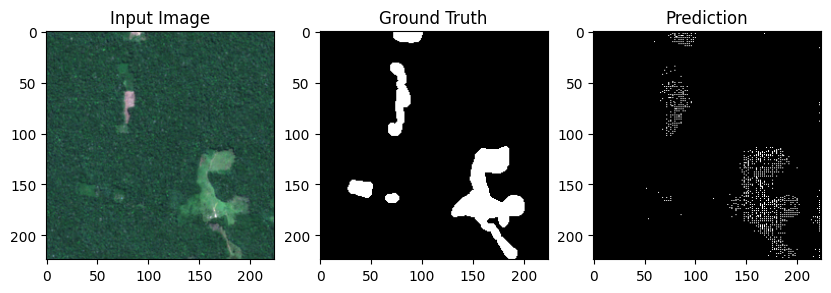

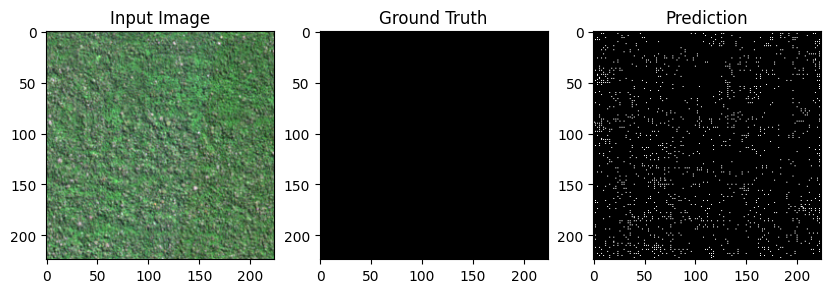

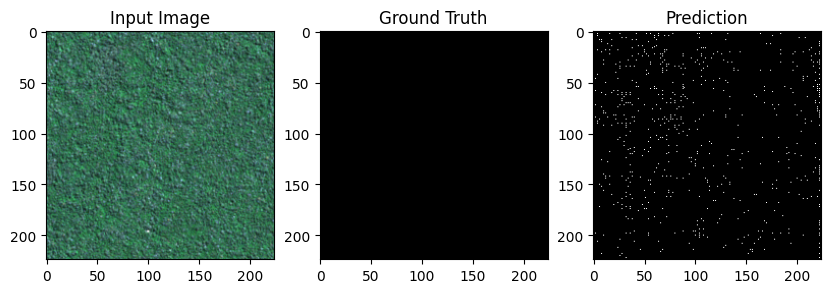

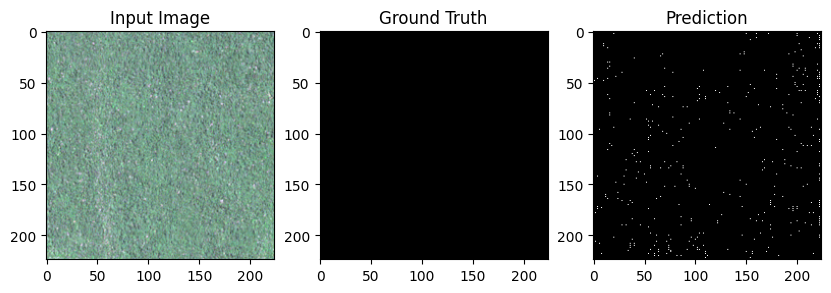

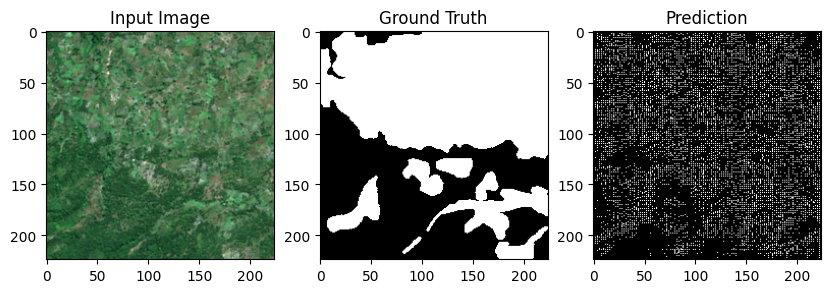

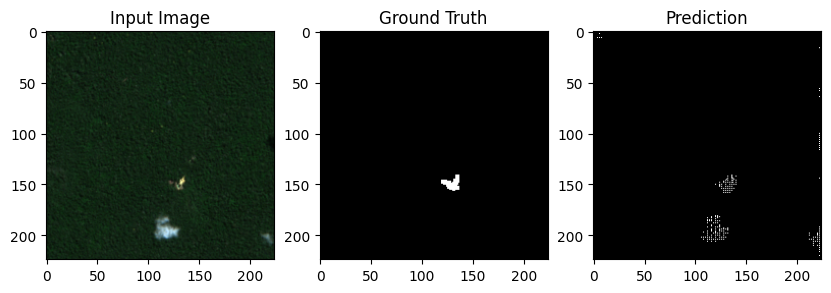

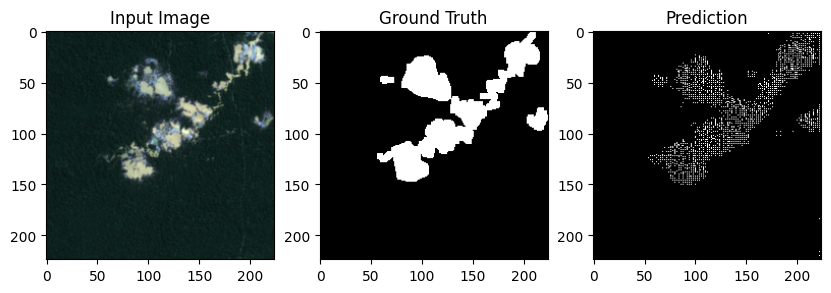

2024-11-19 18:23:29.303416: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [256]:
import matplotlib.pyplot as plt

# Function to display images, ground truth masks, and predicted masks
def display_sample(image, ground_truth, prediction):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()

# Iterate through the test dataset and display results
for images, masks in test_dataset.take(25):  # Display 5 samples
    preds = model.predict(images)
    predicted_masks = (preds>0.3).astype(np.uint8)
    for i in range(len(images)):
        display_sample(images[i].numpy(), masks[i].numpy().squeeze(), predicted_masks[i].squeeze())